In [1]:
import astropy.units as u

from fleck import generate_spots
from fleck import Star

import numpy as np

from altaipony.altai import aflare
import matplotlib.pyplot as plt

from altaipony.utils import generate_random_power_law_distribution

import pytest
from flares import flare_contrast
from decomposeed import decompose_ed_from_UCDs_and_Davenport

import warnings


# upgrade todo

- **DONE** write an empirical `decompose_ed` (see notebook `05`)


# exploration
   
- fix the longitude of dominant spot

In [2]:
t = np.arange(0, 2 * np.pi, 2 * np.pi/600)
n_spots = 1
n_inclinations = 5
emin, emax, alpha, beta = 1e-5, 1e-3, -2, 3


In [3]:
flares = flare_contrast(t, n_spots, emin, emax, alpha, beta, 
                        n_inclinations, 
                        decompose_ed=decompose_ed_from_UCDs_and_Davenport)

[3.84176919e-05 7.30444104e-05 1.81194142e-05]
[9.03925886e-08 1.71285668e-07 4.28018096e-08] [279.0437795  279.98885587 277.94245289]
[1.26036010e-05 1.83671880e-05 1.16488984e-05]
[2.98292053e-08 4.33840039e-08 2.75811136e-08] [277.41205474 277.96231762 277.29709256]
[7.41968939e-05 2.86080682e-05 1.36588089e-05]
[1.73973864e-07 6.74160720e-08 3.23129221e-08] [280.01192101 278.61120623 277.52944661]
[1.88216308e-05 1.13613414e-05 1.26309405e-05]
[4.44517014e-08 2.69038007e-08 2.98935696e-08] [277.99806843 277.26062341 277.41521779]
[1.05090551e-05 1.04511420e-05 1.26151054e-05]
[2.48957830e-08 2.47593073e-08 2.98562896e-08] [277.14687863 277.13881984 277.41338656]


In [7]:
flares.shape

(600, 1, 5)

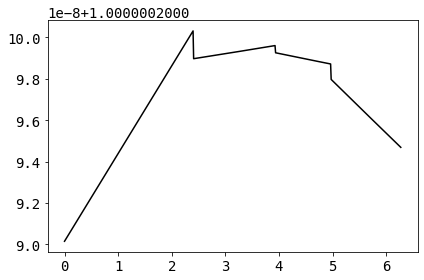

In [5]:
plt.plot(t, flares[:,0,0], c="k")

In [ ]:
u_ld = [0.5079, 0.2239]

n_phases = 1
phases = t * u.rad

# infer active region radius for each lc
spot_radius = np.array([0.01]*n_spots).reshape((n_spots,1))   # Rspot/Rstar , should be the same shape as nspotnincflare
min_latitude = 50  # deg
max_latitude = 60   # deg

# replace with generate_active_regions()
lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                n_inclinations=n_inclinations)



In [ ]:
star = Star(spot_contrast=flares, phases=phases, u_ld=u_ld, n_phases=1)

In [ ]:
lcs = star.light_curve(lons, lats, radii, inc_stellar)

In [ ]:
# should be (phases, n_inclinations)
lcs.shape == (len(t), n_inclinations)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
# plt.plot(star.phases/2/np.pi, (lcs-1).sum(axis=1), c="k")
plt.plot(star.phases/2/np.pi, lcs, c="k")
plt.xlim(0,1)
plt.xlabel("stellar rotational phase", fontsize=14)
plt.ylabel("relative stellar flux", fontsize=14)
plt.legend(fontsize=15, loc=1, frameon=False);
# plt.yscale("log")
plt.title(f"{n_spots} flaring spot between {min_latitude:2d} and {max_latitude:2d} deg latitude,"
          f" at {n_inclinations:2d} different inclinations\n"
          f"same flaring properties per spot, but not the same exact flares\n"
          f"sum of  signal, beta={beta:.1f}", fontsize=15);
# plt.savefig(f"plots/2021_12_20_{n_spots}_spots_distribution_{min_latitude:2d}_{max_latitude:2d}_"
#             f"sum_{n_inclinations:2d}_{beta[0]:.1f}_3.png", dpi=300);